In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [2]:
df=pd.read_csv('train.csv')
df.shape

(404290, 6)

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


* In question2 , we have 2 null values
* In question 1, we have 1 null value

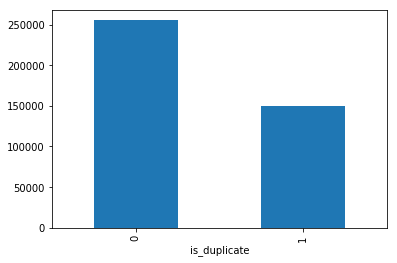

In [5]:
df.groupby('is_duplicate')['id'].count().plot.bar()

percentage of 0's and 1's in is_duplicate label

In [6]:
dup_0=df[df['is_duplicate']==0].shape[0]
dup_1=df.shape[0]-dup_0

In [7]:
print("Percentage of 0's or not duplicates in dataset: {0:.2f}".format(dup_0*100/(dup_0+dup_1)))
print("Percentage of 1's or duplicates in dataset: {0:.2f}".format(dup_1*100/(dup_0+dup_1)))

Percentage of 0's or not duplicates in dataset: 63.08
Percentage of 1's or duplicates in dataset: 36.92


In [8]:
#number of unique questions in the dataset
from collections import Counter
q_list1=df['qid1'].tolist()
q_list2=df['qid2'].tolist()
q_list1.extend(q_list2)
c=Counter(q_list1)


In [9]:
print("Number of unique questions in dataset: ",len(c.values()))
print("Maximum number of times a question is repeated :  ",max(c.values()))
print("Number of times questions are repeated in dataset: ",sum(c.values())-len(c.values()))
t=0
for i in c.values():
    if i>1:
        t+=1
print("Number of unique questions that are repeated: ",t)

Number of unique questions in dataset:  537933
Maximum number of times a question is repeated :   157
Number of times questions are repeated in dataset:  270647
Number of unique questions that are repeated:  111780


In [10]:
#checking whether there are any duplicate pairs
group_df_count=df.groupby(['qid1','qid2']).count().shape[0]
print("Number of duplicate pairs: ",group_df_count-df.shape[0])

Number of duplicate pairs:  0


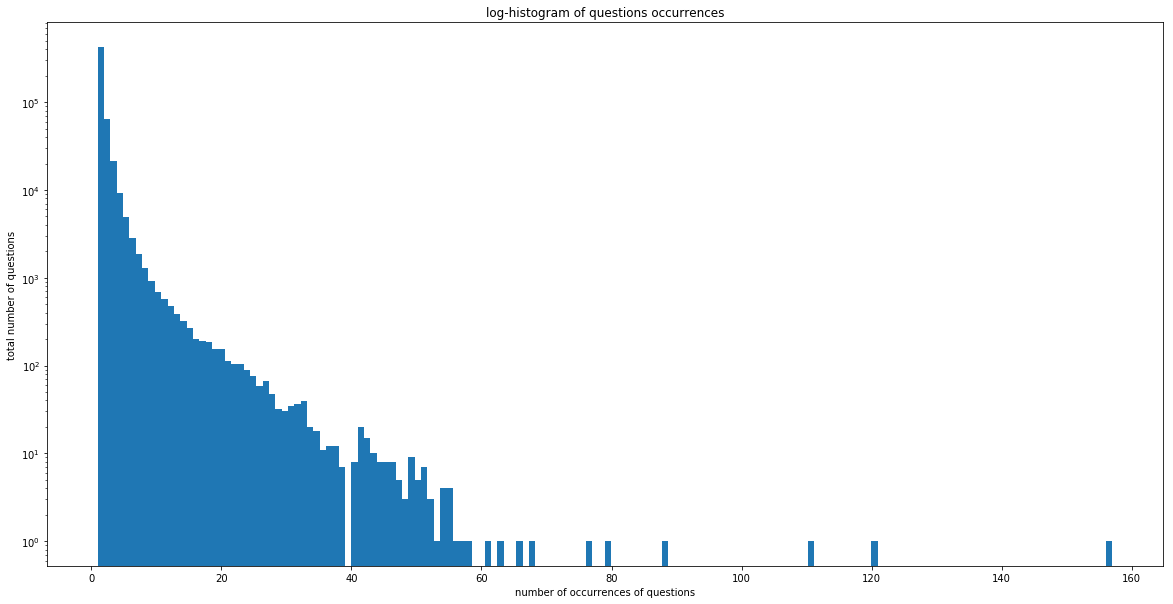

In [11]:
plt.figure(figsize=(20,10))
plt.hist(c.values(),bins=160)
plt.yscale('log',nonposy='clip')
plt.title('log-histogram of questions occurrences')
plt.xlabel('number of occurrences of questions')
plt.ylabel('total number of questions')
plt.show()

### The above graph shows that there are a lot of questions which are not repeated

In [12]:
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
df.fillna(' ',inplace=True)


In [14]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


No more null values are present

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

Let's check out minimum length of question1 and question2 and  number of questions having that length 

In [16]:
print("minimum length of question 1: ",df['q1_n_words'].min())
print("minimum length of question 2: ",df['q2_n_words'].min())
t1=df['q1_n_words'].min()
t2=df['q2_n_words'].min()

minimum length of question 1:  1
minimum length of question 2:  1


In [17]:
print("number of question 1 with minimum length: ",df[df['q1_n_words']==t1].shape[0])
print("number of question 2 with minimum length: ",df[df['q2_n_words']==t2].shape[0])

number of question 1 with minimum length:  66
number of question 2 with minimum length:  22


### Feature: word_share 

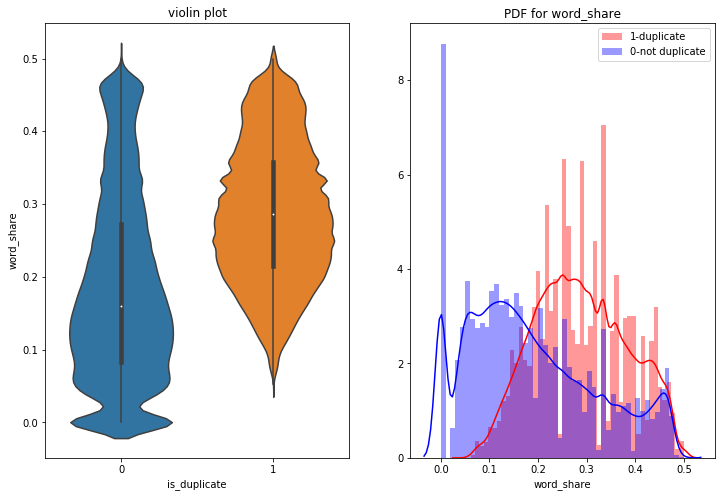

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df)
plt.title('violin plot')
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1]['word_share'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['word_share'],color='blue',label='0-not duplicate')
plt.title('PDF for word_share')
plt.legend()
plt.show()


### We can see that as the word_share increases, there are more chances they are similar

### Next feature : word_Common

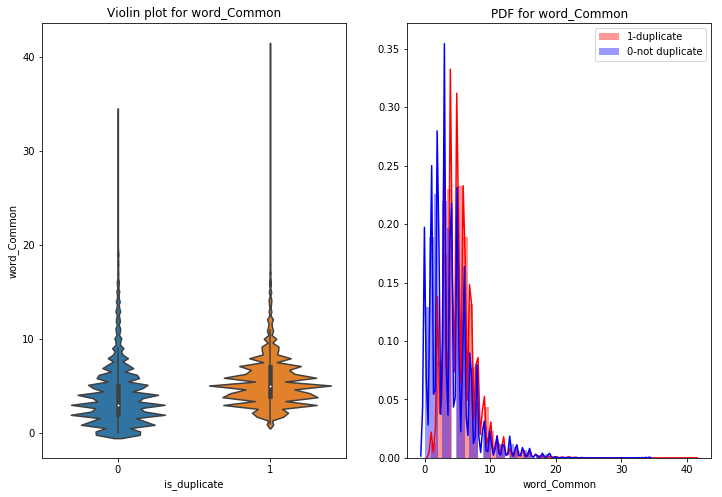

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=df)
plt.title('Violin plot for word_Common')
plt.subplot(1,2,2)
plt.title('PDF for word_Common')
sns.distplot(df[df['is_duplicate']==1]['word_Common'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['word_Common'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


### We can see that graphs are highly overlapping, word_Common may not be that useful as compared to word_share

### Next feature: freq_q1+q2

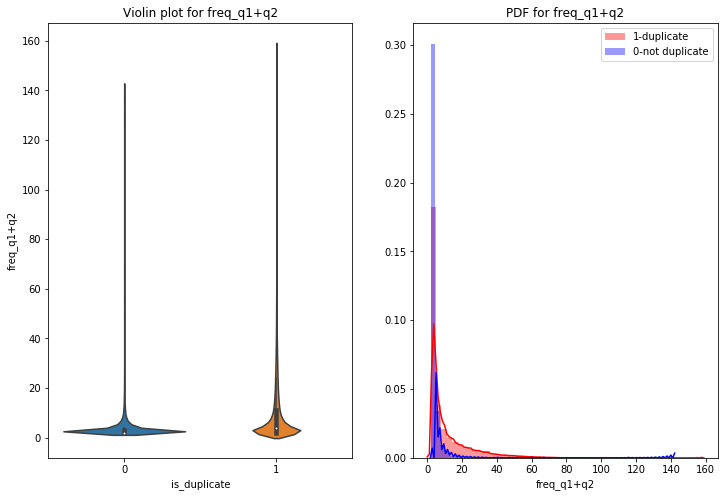

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Violin plot for freq_q1+q2')
sns.violinplot(x='is_duplicate',y='freq_q1+q2',data=df)
plt.subplot(1,2,2)
plt.title('PDF for freq_q1+q2')
sns.distplot(df[df['is_duplicate']==1]['freq_q1+q2'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['freq_q1+q2'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


### Next feature: freq_q1-q2

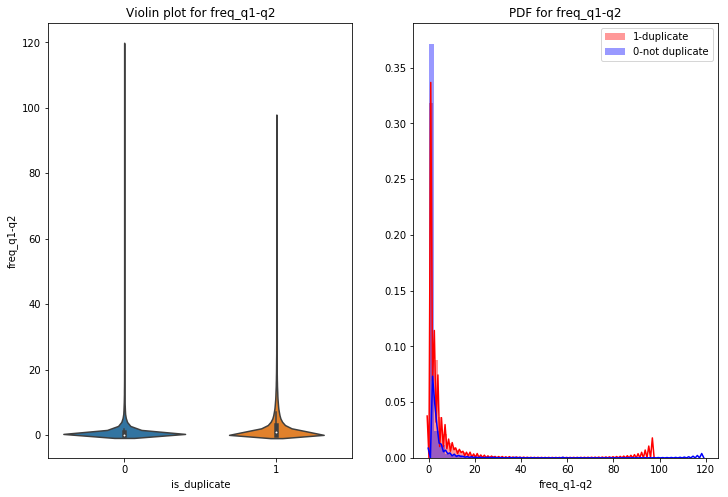

In [21]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Violin plot for freq_q1-q2')
sns.violinplot(x='is_duplicate',y='freq_q1-q2',data=df)
plt.subplot(1,2,2)
plt.title('PDF for freq_q1-q2')
sns.distplot(df[df['is_duplicate']==1]['freq_q1-q2'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['freq_q1-q2'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


### Both sum as well as difference of frequencies graphs are highly overlapping , therefore they may not be useful 

Let's check for other features as well

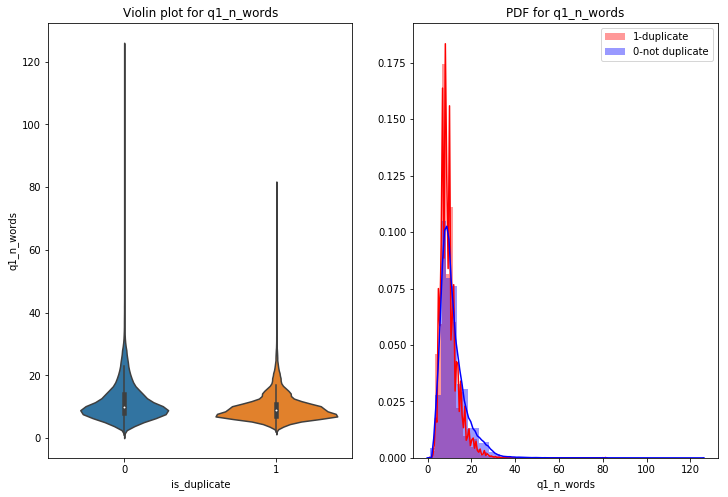

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Violin plot for q1_n_words')
sns.violinplot(x='is_duplicate',y='q1_n_words',data=df)
plt.subplot(1,2,2)
plt.title('PDF for q1_n_words')
sns.distplot(df[df['is_duplicate']==1]['q1_n_words'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['q1_n_words'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


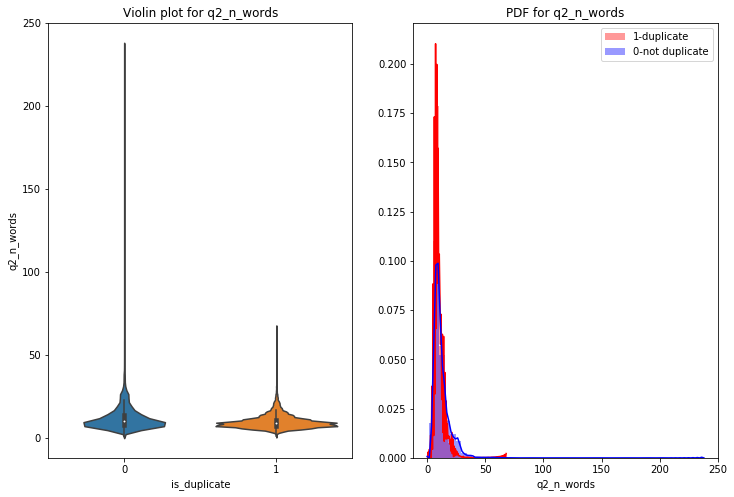

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='q2_n_words',data=df)
plt.title('Violin plot for q2_n_words')
plt.subplot(1,2,2)
plt.title('PDF for q2_n_words')
sns.distplot(df[df['is_duplicate']==1]['q2_n_words'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['q2_n_words'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


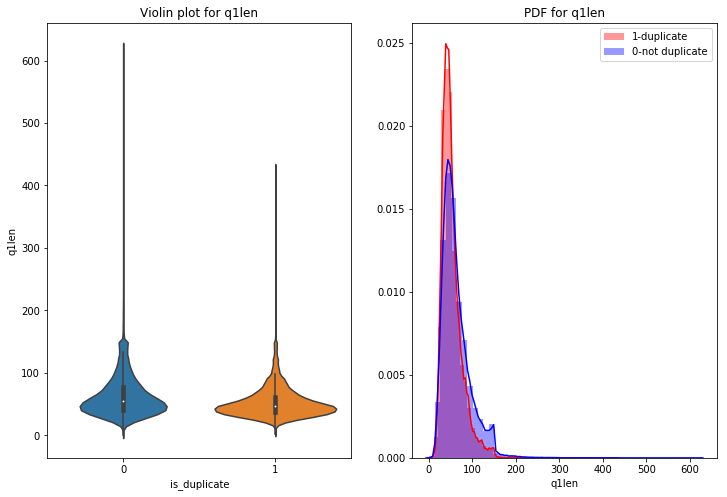

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Violin plot for q1len')
sns.violinplot(x='is_duplicate',y='q1len',data=df)
plt.subplot(1,2,2)
plt.title('PDF for q1len')
sns.distplot(df[df['is_duplicate']==1]['q1len'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['q1len'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


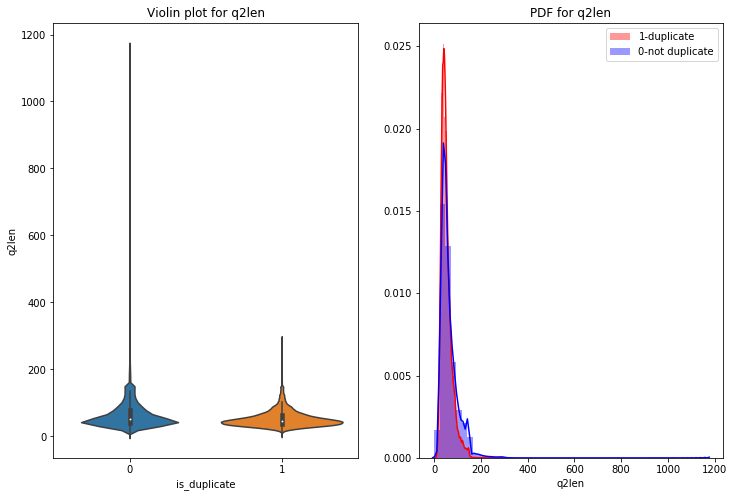

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Violin plot for q2len')
sns.violinplot(x='is_duplicate',y='q2len',data=df)
plt.subplot(1,2,2)
plt.title('PDF for q2len')
sns.distplot(df[df['is_duplicate']==1]['q2len'],color='red',label='1-duplicate')
sns.distplot(df[df['is_duplicate']==0]['q2len'],color='blue',label='0-not duplicate')
plt.legend()
plt.show()


All of the graphs except word_share are highly overlapping

## Text Preprocessing

- Preprocessing:
    - Removing html tags   -> (removing angular brackets )
    - Removing Punctuations   -> (comma , full-stop , exclaimation marks etc)
    - Performing stemming  -> (reducing a word to its base form)
    - Removing Stopwords  -> (removing words which don't add meaning)
    - Expanding contractions etc.-> (replace won't with will not , isn't with is not and so on)

In [26]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ 
<br>
<br>

- __fuzz_partial_ratio__ 
<br>
<br>


- __token_sort_ratio__ 
<br>
<br>


- __token_set_ratio__ 
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min length of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [27]:
%%bash
pip install distance

In [28]:
import distance

In [29]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    

    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [30]:
%%bash
pip install fuzzywuzzy

In [31]:
from fuzzywuzzy import fuzz

C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [32]:
df=extract_features(df)
df.head()

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [33]:
df.to_csv("nlp_features_train.csv", index=False)

### Visualizing our data after feature engineering

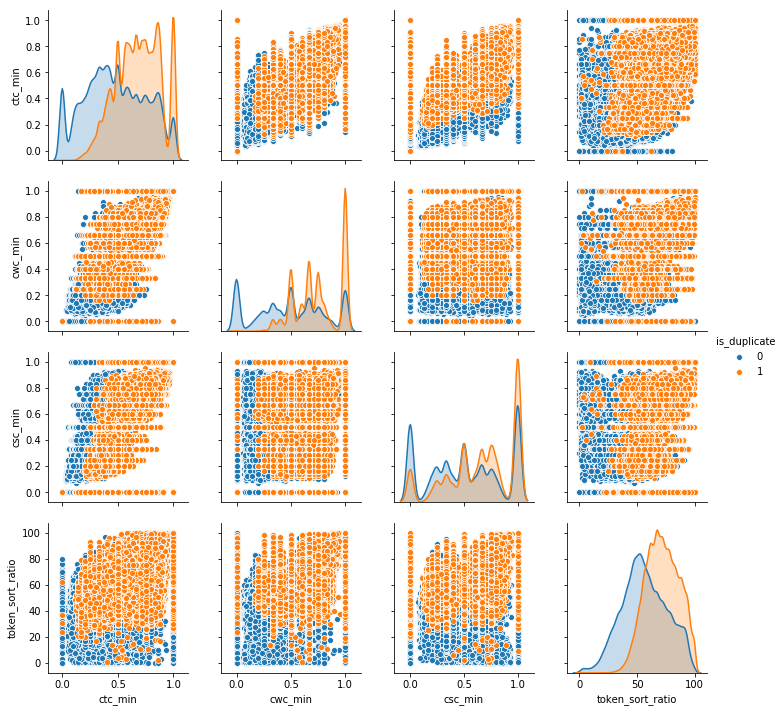

In [34]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

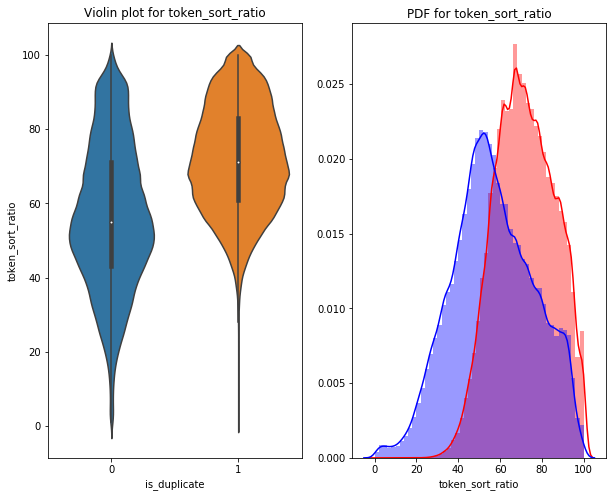

In [35]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.title('Violin plot for token_sort_ratio')
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
plt.title('PDF for token_sort_ratio')
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

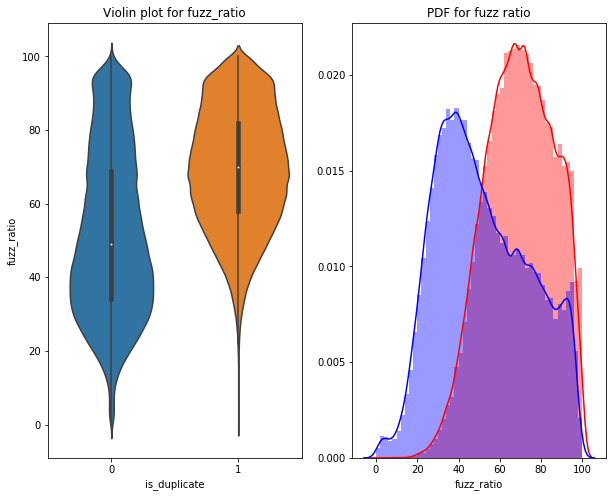

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.title('Violin plot for fuzz_ratio')
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
plt.title('PDF for fuzz ratio')
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### We can see most of our newly generated features are useful in the classification task.
### Let's now see , if our data is seperable in n-dimensional space or not

In [37]:
df=pd.read_csv('nlp_features_train.csv')

In [38]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [39]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.078s...
[t-SNE] Computed neighbors for 10000 samples in 1.224s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.107272
[t-SNE] Computed conditional probabilities in 0.449s
[t-SNE] Iteration 50: error = 95.9266815, gradient norm = 0.0215656 (50 iterations in 6.649s)
[t-SNE] It

C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



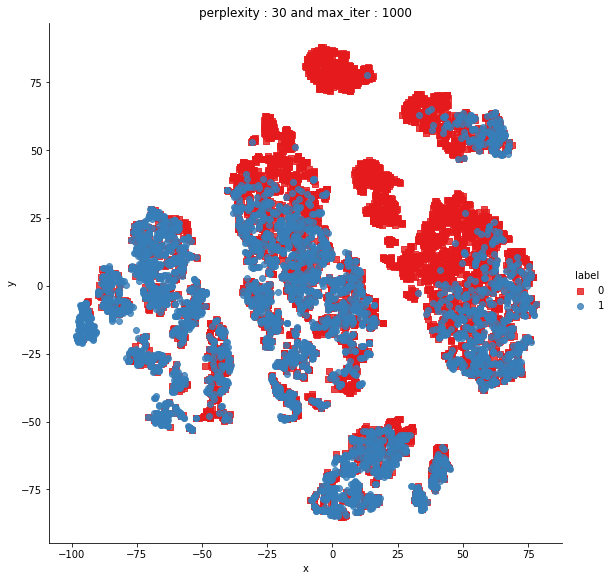

In [40]:
df2 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df2, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

### To convert questions (text) into numeric value , we'll use avg TF-IDF Glove Vector.
### GLOVE is similar to W2V , except It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [41]:
%%bash
pip install spacy

In [42]:
import spacy

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))



In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [44]:
%%bash 
python -m spacy link en_core_web_sm en

symbolic link created for C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\spacy\data\en <<===>> C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\en_core_web_sm
[+] Linking successful
C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\en_core_web_sm -->
C:\Users\Anuj\Miniconda3\envs\condaenv\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


In [45]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(df['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


In [46]:
vecs2 = []
for qu2 in list(df['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [47]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,1.0,2.0,13.0,100,93,93,100,0.982759,"[-16.37060210108757, 41.28883385658264, -120.1...","[-25.644441097974777, 26.04762077331543, -95.3..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,1.0,5.0,12.5,86,63,66,75,0.596154,"[-5.153763771057129, 29.407764740288258, 17.14...","[75.7550066113472, 43.677848756313324, -57.794..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,1.0,4.0,12.0,63,63,43,47,0.166667,"[-109.53837031126022, -85.34552472829819, -76....","[-56.39657521247864, 32.96665072441101, -123.4..."
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.0,2.0,12.0,28,24,9,14,0.039216,"[-0.33684587478637695, -39.34616935253143, -84...","[-76.40742760896683, 122.33586978912354, -42.8..."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,1.0,6.0,10.0,67,47,35,56,0.175000,"[-29.080262422561646, 38.42146635055542, -97.7...","[-26.50704789161682, -44.291531443595886, -76...."


In [48]:
df.shape

(404290, 34)

In [49]:
df.to_csv('final_training.csv',index=False)

In [50]:
df.shape

(404290, 34)